In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Audio
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder


In [2]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [3]:
df = pd.read_csv('../Data/features_3_sec.csv')
df.head() 

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [4]:
df.shape

(9990, 60)

In [5]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [6]:
df =df.drop(['filename'],axis=1)

In [7]:
audio_recording = "/Users/triyuliannibasukie/Desktop/Data/genres_original/country/country.00050.wav"
data,  sr = librosa.load(audio_recording)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [8]:
librosa.load(audio_recording, sr=45600)

(array([ 0.04446705,  0.06373049,  0.0576882 , ..., -0.13878523,
        -0.11868108, -0.05903753], dtype=float32),
 45600)

In [9]:
import IPython
IPython.display.Audio(data=data, rate=sr)

## Raw Wave Files

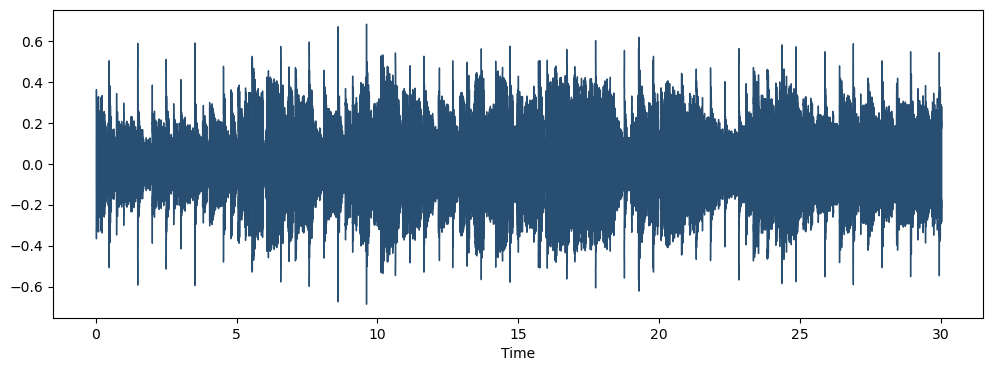

In [10]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, color="#284F72")
plt.show()

## Spectrograms

A spectrogram is a visual way of representing the signal loudness of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

/var/folders/y8/wsglljgs2lg5bx0xg5y6csqm0000gn/T/ipykernel_16781/328754603.py:4: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')


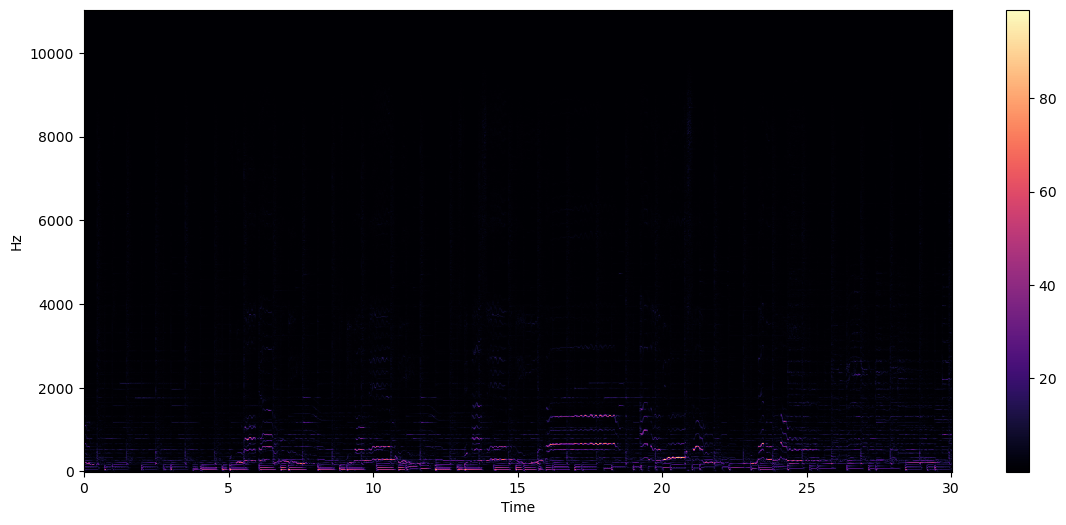

In [11]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## Spectral Rolloff

It is a measure that helps characterize the spectral content of an audio signal by determining the frequency below which a certain percentage of the total spectral energy lies. In simpler terms, spectral rolloff identifies the point in a frequency spectrum below which a specific portion of the signal's energy is concentrated.

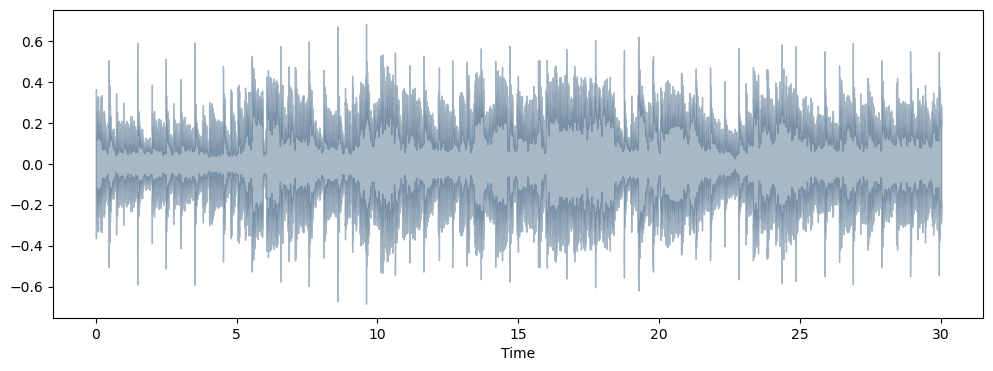

In [13]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(y=data+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.4, color="#284F72")

## Chroma Features

In Western music, the term chroma feature or chromagram closely relates to twelve different pitch classes.
(pitch class = set of all pitches that are a whole number of octaves apart. example: pitch class C stands for all possible Cs, in whatever octave position.)

Chroma-based features (aka "pitch class profiles") are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale.

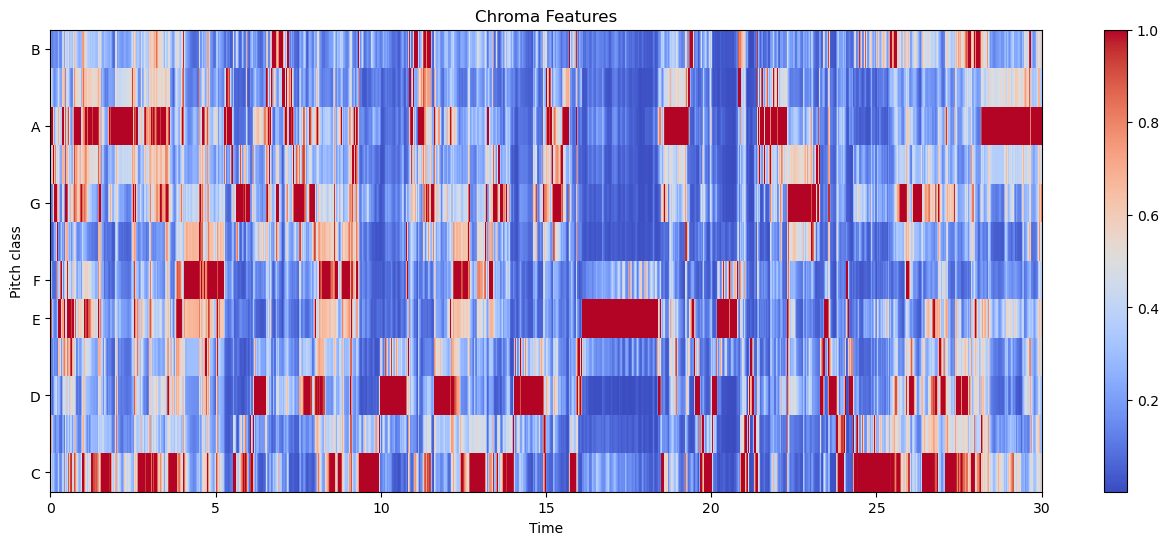

In [14]:
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(y=data, sr=sr)
plt.figure(figsize=(16, 6))
lplt.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

## Zero Crossing Rate

The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive. Its value has been widely used in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.

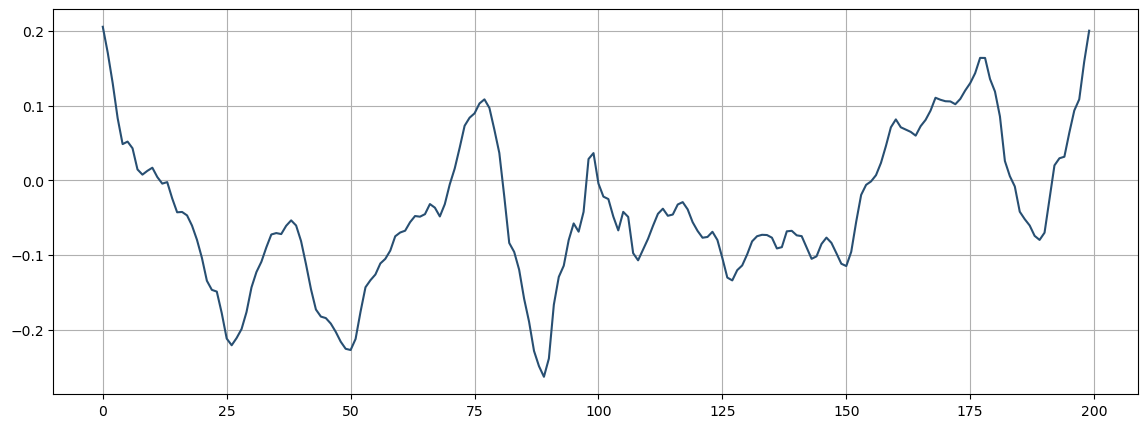

In [15]:
start = 1000
end = 1200
plt.figure(figsize=(14,5))
plt.plot(data[start:end], color="#284F72")
plt.grid()

In [16]:
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print(f"The number of zero-crossings is :", sum(zero_cross_rate))

The number of zero-crossings is : 8


## Feature Extraction



In [17]:
class_list = df.iloc[:, -1]
convertor = LabelEncoder()
print(class_list)
y = convertor.fit_transform(class_list)
print(df.iloc[:, :-1])

0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object
      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.

In [18]:
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype = float))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("y_train:", len(y_train))
print("y_test:", len(y_test))

y_train: 7992
y_test: 1998


## Generating a Model                                                                                                     

In [20]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

## Hyperparameter Tuning

In [21]:
# Import scikit-learn metrics module for accuracy and other metric calculations
from sklearn import metrics

# Model Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)

# Model Precision 
precision_macro = metrics.precision_score(y_test, y_pred, average='macro')

# Model Recall 
recall_macro = metrics.recall_score(y_test, y_pred, average='macro')

# Model F1 Score 
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision_macro)
print("Recall:", recall_macro)
print("F1 Score:", f1_macro)

Accuracy: 0.7552552552552553
Precision: 0.7585460375229818
Recall: 0.7593622951602307
F1 Score: 0.7559494553573916


In [29]:
# Create an SVM classifier
svc = svm.SVC(kernel='rbf')

# a range of values for the hyperparameters C and gamma
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Create a GridSearchCV object to find the best hyperparameters
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=3)

# Fit the model with training data and find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new SVM classifier with the best hyperparameters
best_svc = svm.SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])

# Train the model with the best hyperparameters
best_svc.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_svc.predict(X_test)

# Calculate accuracy and other metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision_macro = metrics.precision_score(y_test, y_pred, average='macro')
recall_macro = metrics.recall_score(y_test, y_pred, average='macro')
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Precision (macro):", precision_macro)
print("Recall (macro):", recall_macro)
print("F1 Score (macro):", f1_macro)


Best Hyperparameters: {'C': 10, 'gamma': 0.01}
Accuracy: 0.9069069069069069
Precision (macro): 0.907147704858518
Recall (macro): 0.9085049914808787
F1 Score (macro): 0.9072910458524946
